In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# load data

In [3]:
def segment_(data,window_size = 7):
    segments = np.empty((0,window_size,2))
    labels = np.empty((0))
    for line in data:
        line = np.array(line).reshape(1,window_size,2)
        segments = np.vstack([segments,line])
    return segments

fault_label = {
    '0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

X, labels = [], [] 

with open("data_msg_type/x.txt", 'rU') as f:
        res = list(f)
        for line in res:
            line.strip("\n")
            features = line.split("\t")
            while features.__contains__(""):
                features.remove("")
            for i in range(len(features)):
                features[i] = float(features[i])
            X.append(features)
            
with open("data_msg_type/y.txt", 'rU') as f:
        res = list(f)
        for line in res:
            labels.append(int(line.strip("\n")[0]))
            

segments = segment_(X)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)

x = segments.reshape(len(segments), 1, 7, 2)
y = labels

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")

Separating data into 80% training set & 20% test set...
Dataset separated.



# define parameters

In [13]:
input_height = 1
input_width = 7
num_channels = 2
num_labels = 10

batch_size = 128
kernel_size = 3
depth = 20
num_hidden = 1000

learning_rate = 0.0001
# iteration times
training_epochs = 100

total_batches = train_x.shape[0] // batch_size

# network config

In [14]:
# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# build network

In [15]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,1,1)
c = apply_depthwise_conv(p,3,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

# loss func
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1], dtype=float)

# train and test

In [16]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", \
          session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    y_pred = tf.argmax(y_, 1)
    y_true = np.argmax(test_y, 1)
    final_acc, y_pred = session.run([accuracy, y_pred], feed_dict={X: test_x, Y: test_y})
    print "Testing Accuracy: {}".format(final_acc)
    print()
    
    # model metrics
    temp_y_true = np.unique(y_true)
    temp_y_pred = np.unique(y_pred) 
    np.save("data/y_true", y_true) 
    np.save("data/y_pred", y_pred) 
    print "temp_y_true", temp_y_true 
    print "temp_y_pred", temp_y_pred
    
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print("confusion_matrix: ")
    print confusion_matrix(y_true, y_pred)

Epoch:  0  Training Loss:  16.9433  Training Accuracy:  0.966161
Epoch:  1  Training Loss:  6.36572  Training Accuracy:  0.98753
Epoch:  2  Training Loss:  3.09731  Training Accuracy:  0.991299
Epoch:  3  Training Loss:  1.45071  Training Accuracy:  0.992805
Epoch:  4  Training Loss:  0.860183  Training Accuracy:  0.99413
Epoch:  5  Training Loss:  0.596208  Training Accuracy:  0.994311
Epoch:  6  Training Loss:  0.444605  Training Accuracy:  0.995493
Epoch:  7  Training Loss:  0.344241  Training Accuracy:  0.997437
Epoch:  8  Training Loss:  0.274428  Training Accuracy:  0.998224
Epoch:  9  Training Loss:  0.225477  Training Accuracy:  0.999255
Epoch:  10  Training Loss:  0.190496  Training Accuracy:  0.999268
Epoch:  11  Training Loss:  0.164617  Training Accuracy:  0.999449
Epoch:  12  Training Loss:  0.144878  Training Accuracy:  0.999449
Epoch:  13  Training Loss:  0.129365  Training Accuracy:  0.999461
Epoch:  14  Training Loss:  0.116859  Training Accuracy:  0.999461
Epoch:  15 

# evalution

In [ ]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}

#matplotlib.rc('font', **font)

#width = 12
#height = 12
#plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(config.batch_size, 
    (len(train_losses)+1)*config.batch_size, config.batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(config.batch_size, 
    len(test_losses)*config.display_iter, config.display_iter)[:-1]), 
    [config.training_epochs])

plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

# confusion matrix

               precision    recall  f1-score   support

     security       1.00      1.00      1.00       279
       others       1.00      1.00      1.00      3115
    processor       1.00      1.00      1.00      5774
         disk       1.00      1.00      1.00        16
      network       1.00      1.00      1.00       248
         file       1.00      1.00      1.00     29818
     database       1.00      1.00      1.00        64
      service       1.00      1.00      1.00       479
       memory       1.00      1.00      1.00       207

  avg / total       1.00      1.00      1.00     40000

[[  279     0     0     0     0     0     0     0     0]
 [    0  3115     0     0     0     0     0     0     0]
 [    0     0  5774     0     0     0     0     0     0]
 [    0     0     0    16     0     0     0     0     0]
 [    0     0     0     0   248     0     0     0     0]
 [    0     0     0     0     0 29818     0     0     0]
 [    0     0     0     0     0     0    64     0 

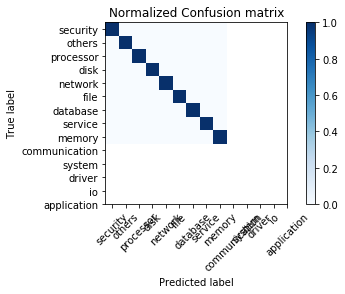

In [18]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', 
                          cmap=plt.cm.get_cmap("Blues")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    #print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks =np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=45) 
    plt.yticks(tick_marks, fault_label.values()) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_(): 
    y_true = np.load("data/y_true.npy") 
    y_pred = np.load("data/y_pred.npy") 
    print(classification_report(y_true, y_pred, 
          target_names = fault_label.values()))
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_()